<a href="https://colab.research.google.com/github/srimangithubin/micrograd_for_single_neuron/blob/main/micrograd_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [5]:
class Value:
  def __init__(self,data,_children=(),_op='',label=''):
    self.data=data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev=set(_children)
    self._op = _op
    self.label = label
  def __repr__(self):
    return f"value(data={self.data})"

  def __add__(self,other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data,(self,other),'+')

    def _backward():
      self.grad += 1 * out.grad   # Mutivariate differential chain rule
      other.grad += 1 * out.grad
    out._backward = _backward

    return out

  def __mul__(self,other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data,(self,other),'*')

    def _backward():
      self.grad  += out.grad * other.data
      other.grad += out.grad * self.data
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t,(self,),'tanh')

    def _backward():
      self.grad += (1-t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1
    for node in reversed(topo):
      node._backward()


a = Value(2.0, label='a') # Set label for each value object.
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2, label='f')
L =d*f; L.label='L'
print(L._prev)
print('operation = ',L._op)
print('L =',L)

{value(data=-2), value(data=4.0)}
operation =  *
L = value(data=-8.0)


In [20]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

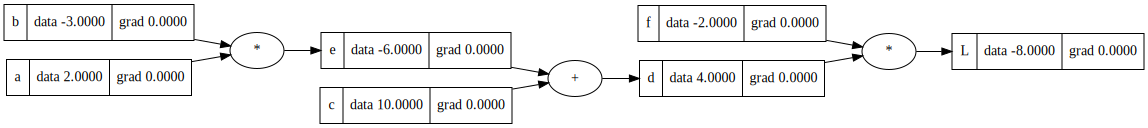

In [4]:
draw_dot(L)

In [ ]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-8.0


In [ ]:
def lol():

  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  c.data+=h
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

-1.9999999999988916


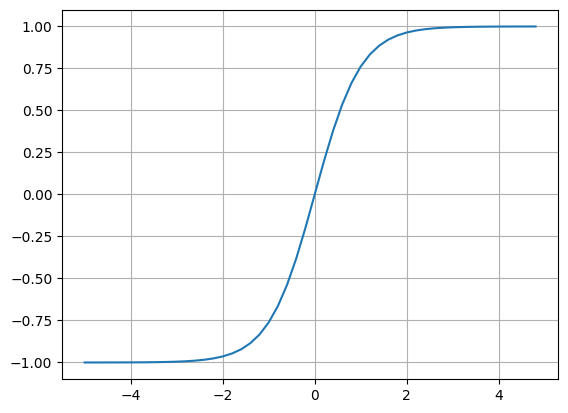

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

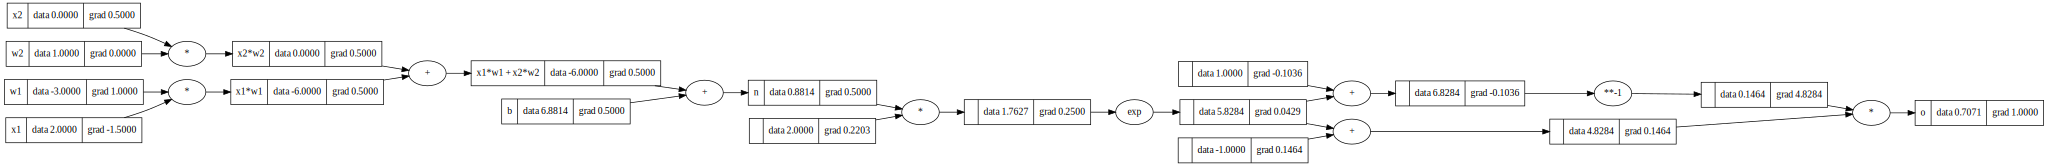

In [22]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [5]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

Auto backpropagation with auto differentiation

In [6]:
o.backward()

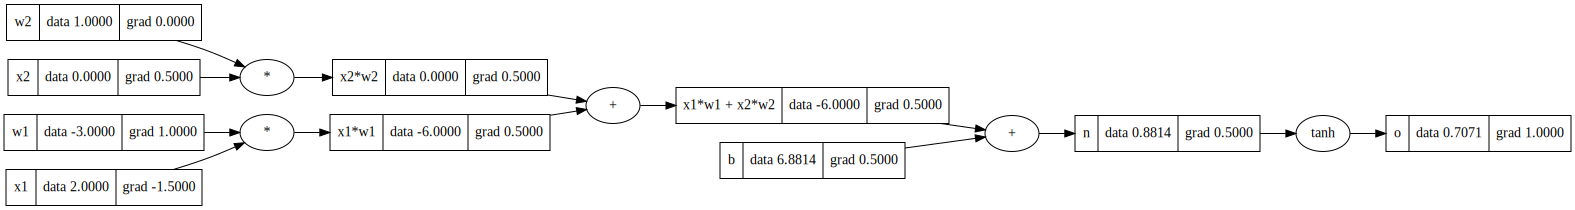

In [7]:
draw_dot(o)

In [8]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[value(data=-3.0),
 value(data=2.0),
 value(data=-6.0),
 value(data=1.0),
 value(data=0.0),
 value(data=0.0),
 value(data=-6.0),
 value(data=6.881373587019543),
 value(data=0.8813735870195432),
 value(data=0.7071067811865476)]

Manual backpropagation with auto differentiation

In [ ]:
o.grad = 1

In [ ]:
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

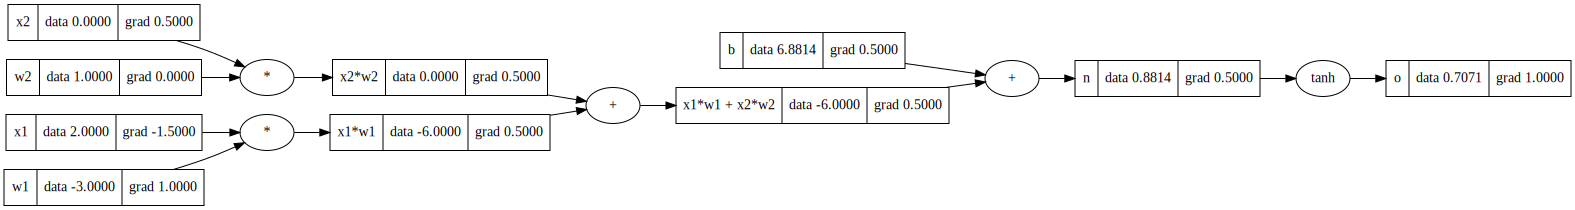

In [ ]:
draw_dot(o)

Manual Back propagation

In [ ]:
# o = math.tanh(n)
# o.grad = 1
# # do/dn = 1 - o**2
# # 1 - o.data**2  -----> 0.49999999
# n.grad = 0.5
# b.grad = 0.5
# x1w1x2w2.grad = 0.5
# x1w1.grad = 0.5
# x2w2.grad = 0.5
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

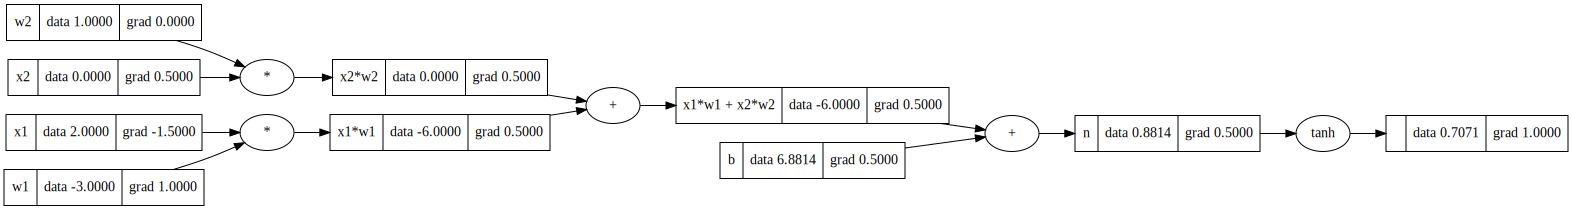

In [ ]:
draw_dot(o)

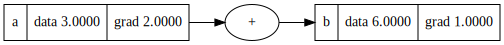

In [ ]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

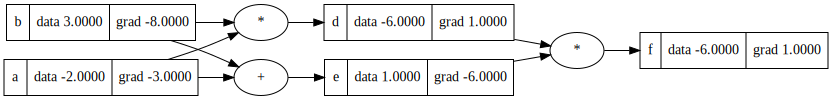

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [23]:
import torch

In [24]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [2]:
import random

In [6]:
class Neuron:

  def __init__(self,nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x):
    act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
    # act = sum(wi*xi for wi,xi in zip(self.w,x) + self.b
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]
class Layer:    # collection of neurons

  def __init__(self,nin,nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self,nin,nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i],sz[i+1])for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

random.seed(42)
x = [2,3,-1]
n = MLP(3,[4,4,1])
n(x)

value(data=0.6994093620224068)

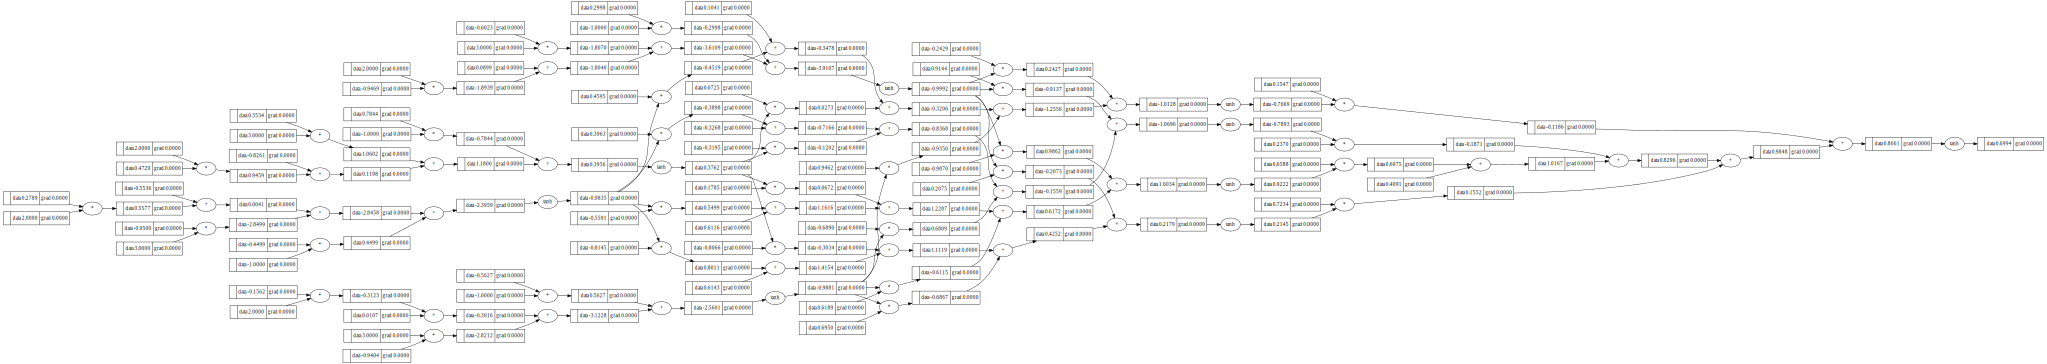

In [24]:
draw_dot(n(x))

In [7]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [12]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 0.014530810435106043
1 0.014102136627820571
2 0.013696460075557748
3 0.013312027570392952
4 0.01294725710702131
5 0.01260071767183374
6 0.012271111811707041
7 0.011957260548403901
8 0.011658090280016492
9 0.011372621371991461
10 0.011099958189934154
11 0.010839280366940093
12 0.01058983513145233
13 0.010350930549028112
14 0.01012192955403731
15 0.009902244666108655
16 0.009691333301794568
17 0.009488693605013136
18 0.009293860730807187
19 0.009106403526200284


In [13]:
ypred

[value(data=0.9535173420601789),
 value(data=-0.9750472907342631),
 value(data=-0.9348651427167394),
 value(data=0.9543866389745422)]